In [1]:
from Ornstein_Uhlenbeck import Ornstein_Uhlenbeck
from results_generator import *
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
import backtrader as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyfolio as pf
import warnings

/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
np.seterr(all="ignore")
warnings.simplefilter('ignore', pd.errors.PerformanceWarning)

In [3]:
stock_list = pd.read_csv('data/stock_list.csv')['0']
obs = 252 # number of observations used by the model
cash = 100000000
commission = 0.004
stock_dict = {}
for stock in stock_list:
    stock_dict[stock] = pd.read_csv('data/{}.csv'.format(stock), index_col='Date', parse_dates=['Date'])
    stock_dict[stock]['Close'] = stock_dict[stock]['Adj Close']
    stock_dict[stock]['Open'] = stock_dict[stock]['Adj Close'].shift(1)
    stock_dict[stock] = stock_dict[stock].dropna()

In [4]:
class PandasData(bt.feeds.PandasData):
    lines = ('open', 'high', 'low', 'close', 'volume')
    params = (('datetime', None),
              ('open', 0),
              ('high', 1),
              ('low', 2),
              ('close', 3),
              ('adjclose', 4),
              ('volume', 5))

In [5]:
def get_hurst_exponent(time_series, max_lag=20):
    lags = range(2, max_lag)

    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    
    reg = np.polyfit(np.log(lags), np.log(tau), 1)

    return reg[0]

In [12]:
class MyStrategy(bt.Strategy):
    def __init__(self):
        self.obs = obs
        self.n = 0 # number of days
        self.max_n = stock_dict[stock_list[0]].shape[0]
        self.pos = 0 # initial position
        self.holding_period = 0
        self.leverage = 3
        self.max_buy_portion = 0.9
        
        # stocks selection
        self.req_corr = 0.7
        self.req_adf = 0.01
        self.req_hurst = 0.5
        
        # model settings
        self.model = None
        self.model_list = None
        self.idx_list = None
        self.a, self.b = None, None # index of Sta and Stb
        self.z = norm.ppf(0.99)
        
        # logging the process
        self.date_list = []
        self.Xt_list = []
        self.lb_list = []
        self.ub_list = []

    def signal_generation(self):
        if self.model_list is None or self.n >= self.max_n - 1:
            return 0
        
        if self.model is not None:
            self.Xt = self.model.alpha * self.Sta[-1] - self.model.beta * self.Stb[-1]
            
            if self.holding_period > 0:
                self.holding_period -= 1
                return self.pos
    
            if self.pos == 1:
                if self.Xt >= self.EX:
                    return 0
                else:
                    return 1
            elif self.pos == -1:
                if self.Xt <= self.EX:
                    return 0
                else:
                    return -1
        else: # to check is the model in the model_list can start the trade
            for i, model in enumerate(self.model_list):
                self.Sta = np.array(self.datas[self.idx_list[i][0]].close.get(size=self.obs))
                self.Stb = np.array(self.datas[self.idx_list[i][1]].close.get(size=self.obs))
                self.Xt = model.alpha * self.Sta[-1] - model.beta * self.Stb[-1]
                self.update_statistics(model)
                if self.Xt > self.EX + self.z * np.sqrt(self.VarX):
                    self.holding_period = 252 // 12
                    self.model = model
                    self.a, self.b = self.idx_list[i][0], self.idx_list[i][1]
                    self.corr = self.corr_list[i]
                    self.adf = self.adf_list[i]
                    self.hurst = self.hurst_list[i]
                    return -1
                elif self.Xt < self.EX - self.z * np.sqrt(self.VarX):
                    self.holding_period = 252 // 12
                    self.model = model
                    self.a, self.b = self.idx_list[i][0], self.idx_list[i][1]
                    self.corr = self.corr_list[i]
                    self.adf = self.adf_list[i]
                    self.hurst = self.hurst_list[i]
                    return 1
            return 0
    
    def update_statistics(self, model):
        self.EX = model.mu
        self.VarX = model.sigma2 / (2 * model.theta)
    
    def renew_model_list(self):
        stock_df = pd.DataFrame()
        for i, stock in enumerate(stock_list):
            stock_df[i] = np.array(self.datas[i].close.get(size=self.obs))
        corr = stock_df.pct_change().corr()
        model_list = []
        idx_list = []
        corr_list = []
        hurst_list = []
        adf_list = []
        metrics_list = []
        for i in range(len(stock_list)):
            for j in range(i):
                if corr[i][j] > self.req_corr: # quick test to choose the appropriate pairs
                    model1 = Ornstein_Uhlenbeck(stock_df[i].values, stock_df[j].values)
                    model2 = Ornstein_Uhlenbeck(stock_df[j].values, stock_df[i].values)
                    swap = 0
                    if model1.l is None and model2.l is None:
                        model = None
                    elif model1.l is None and model2.l is not None:
                        model = model2
                        swap = 1
                    elif model1.l is not None and model2.l is None:
                        model = model1
                    else:
                        if model1.l >= model2.l:
                            model = model1
                        else:
                            model = model2
                            swap = 1
                    
                    hurst = get_hurst_exponent(model.X)
                    adf = adfuller(model.X)
                    if hurst < self.req_hurst and adf[1] < self.req_adf:
                        model_list.append(model)
                        idx_list.append((i, j)) if swap == 0 else idx_list.append((j, i))
                        corr_list.append(corr[i][j])
                        hurst_list.append(hurst)
                        adf_list.append(adf)
                        metrics_list.append(hurst * adf[1] * (1 - corr[i][j]))
        # sort based on the defined metrics 
        if len(model_list) > 0:
            rank_list = np.argsort(metrics_list)
            self.model_list = [model_list[i] for i in rank_list]
            self.idx_list = [idx_list[i] for i in rank_list]
            self.corr_list = [corr_list[i] for i in rank_list]
            self.hurst_list = [hurst_list[i] for i in rank_list]
            self.adf_list = [adf_list[i] for i in rank_list]
        
    def close_positions(self): # to close all existing positions
        self.close(data=self.datas[self.a])
        self.close(data=self.datas[self.b])
    
    def logging(self):
        self.date_list.append(self.data.datetime.date())
        if self.model is not None:
            self.Xt_list.append(self.Xt)
            self.lb_list.append(self.EX - self.z * np.sqrt(self.VarX))
            self.ub_list.append(self.EX + self.z * np.sqrt(self.VarX))
        else:
            self.Xt_list.append(0)
            self.lb_list.append(0)
            self.ub_list.append(0)

        if self.date_list[-1] == self.last_day:
            plt.figure(figsize=(10, 6))
            plt.plot(self.date_list, self.lb_list, label='Lower Bound')
            plt.plot(self.date_list, self.ub_list, label='Upper Bound')
            plt.plot(self.date_list, self.Xt_list, label=r'$X_t$')
            plt.legend()
    
    def start(self):
        self.last_day = self.data.datetime.date(-1)  # Get the last available date
        
    def next(self): 
        self.n += 1
        if self.n >= self.obs:
            if self.model_list is None:
                self.renew_model_list()
            if self.model is not None:
                self.Sta = np.array(self.datas[self.a].close.get(size=self.obs))
                self.Stb = np.array(self.datas[self.b].close.get(size=self.obs))
            
        self.signal = self.signal_generation()
        
        if self.signal != 0 and self.pos == 0:
            print('Number of Pairs: {} | Best Pair\'s Correlation: {:.2f} | Best Pair\'s Hurst Exponent: {:.2f} | Best Pair\'s p-value: {:.2f}'.format(len(self.model_list), self.corr, self.hurst, self.adf[1]))
    
        if self.signal == 1:
            if self.pos == 0:
                k = self.leverage / (self.Sta[-1] * self.model.alpha + self.model.beta * self.Stb[-1])
                k = np.min([k, 1 / (self.model.alpha * self.Sta[-1])])
                self.buy(data=self.datas[self.a], size=self.max_buy_portion * cerebro.broker.get_value() * self.model.alpha * k)
                self.sell(data=self.datas[self.b], size=self.max_buy_portion * cerebro.broker.get_value() * self.model.beta * k)
                print("{}: Long {} and short {} when Xt = {:.2f}".format(self.data.datetime.date(), stock_list.loc[self.a], stock_list.loc[self.b], self.Xt))
                
        elif self.signal == -1:
            if self.pos == 0:
                k = self.leverage / (self.Sta[-1] * self.model.alpha + self.model.beta * self.Stb[-1])
                k = np.min([k, 1 / (self.model.beta * self.Stb[-1])])
                self.buy(data=self.datas[self.b], size=self.max_buy_portion * cerebro.broker.get_value() * self.model.beta * k)
                self.sell(data=self.datas[self.a], size=self.max_buy_portion * cerebro.broker.get_value() * self.model.alpha * k)
                print("{}: Short {} and long {} when Xt = {:.2f}".format(self.data.datetime.date(), stock_list.loc[self.a], stock_list.loc[self.b], self.Xt))
                
        else: # self.signal == 0
            if self.pos != 0:
                self.close_positions()
                self.model = None
                print("{}: Close pair when Xt = {:.2f}".format(self.data.datetime.date(), self.Xt))
                
        self.pos = self.signal
        
        if self.n >= self.obs:
            self.logging()
            
            if self.pos == 0:
                self.model_list = None

In [13]:
# backtest settings
cerebro = bt.Cerebro()

data_feed_dict = {}
for stock in stock_list:
    data_feed_dict[stock] = PandasData(dataname=stock_dict[stock], name=stock)
    cerebro.adddata(data_feed_dict[stock])

cerebro.addstrategy(MyStrategy)
cerebro.broker.setcash(cash)
cerebro.broker.setcommission(commission=commission)

In [14]:
# Run the backtest
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
results = cerebro.run()
pyfolio_analyzer = results[0].analyzers.pyfolio
returns, positions, transactions, gross_lev = pyfolio_analyzer.get_pf_items()

KeyboardInterrupt: 

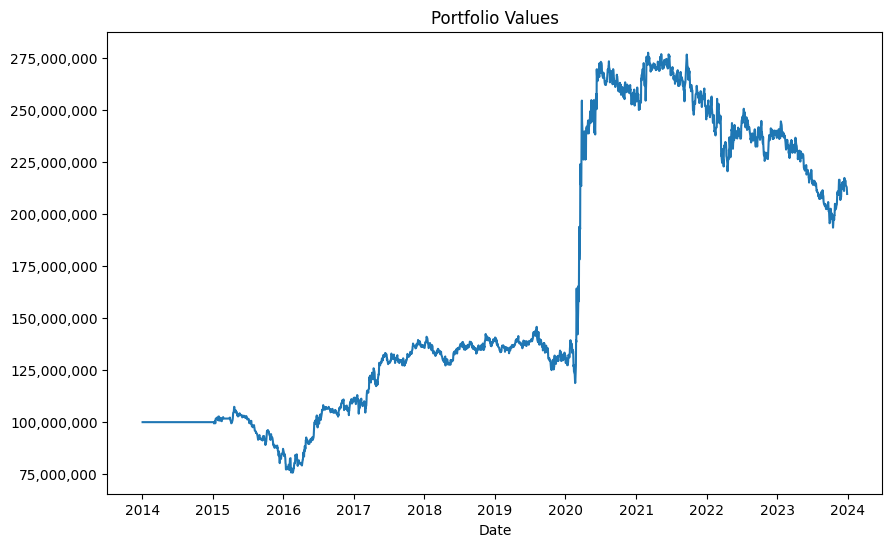

In [9]:
plot_portfolio_values(cash, returns)

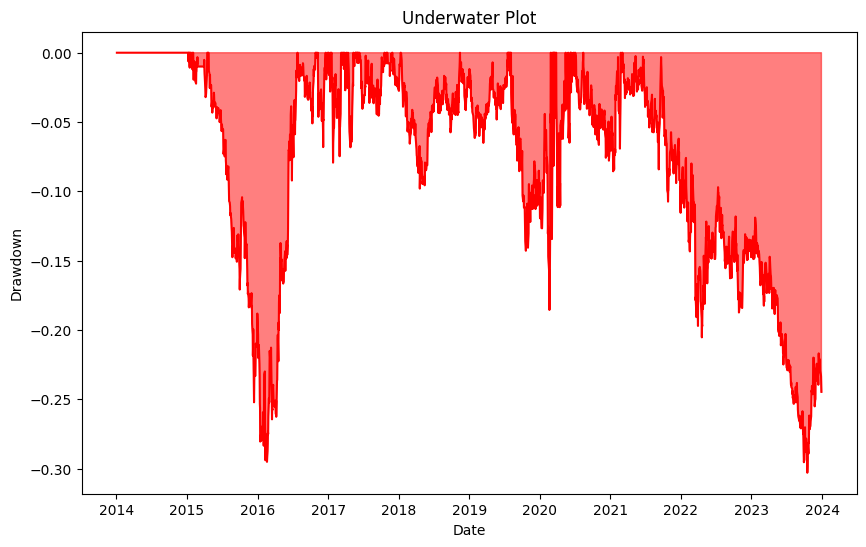

In [10]:
plot_underwater(returns)

                     In-sample Out-of-sample        All
Annual return            15.2%         -9.0%       7.7%
Cumulative returns      174.0%        -23.5%     109.7%
Annual volatility        20.8%         14.7%      19.2%
Sharpe ratio           0.78102     -0.570241   0.479929
Calmar ratio          0.513727     -0.297153   0.254247
Stability             0.706745      0.872873   0.798584
Max drawdown            -29.5%        -30.3%     -30.3%
Omega ratio           1.203407      0.909895   1.110658
Sortino ratio         1.366329     -0.780684   0.799298
Skew                  3.045125      -0.08692   2.758766
Kurtosis             38.069908      1.369734  37.579844
Tail ratio            1.096144      0.901626   1.027002
Daily value at risk      -2.6%         -1.9%      -2.4%


/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will b

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.29,2021-03-04,2023-10-17,NaT,NaN
1,29.51,2015-04-22,2016-02-19,2016-07-26,330
2,18.55,2019-08-05,2020-02-20,2020-02-27,149
3,13.44,2020-02-28,2020-03-04,2020-03-09,7
4,11.14,2020-03-26,2020-04-13,2020-05-14,36


/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:1139: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/timeseries.py:1139: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/plotting.py:1305: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.boxplot(data=[is_returns, is_weekly, is_monthly],
/Users/jeffrey/PycharmProjects/fina4380/.venv/lib/python3.9/site-packages/pyfolio/plotting.py:1321: UserWarning: set_tic

Stress Events,mean,min,max
Apr14,0.00%,0.00%,0.00%
Oct14,0.00%,0.00%,0.00%
Fall2015,-0.14%,-2.04%,1.45%
New Normal,0.04%,-10.89%,16.22%


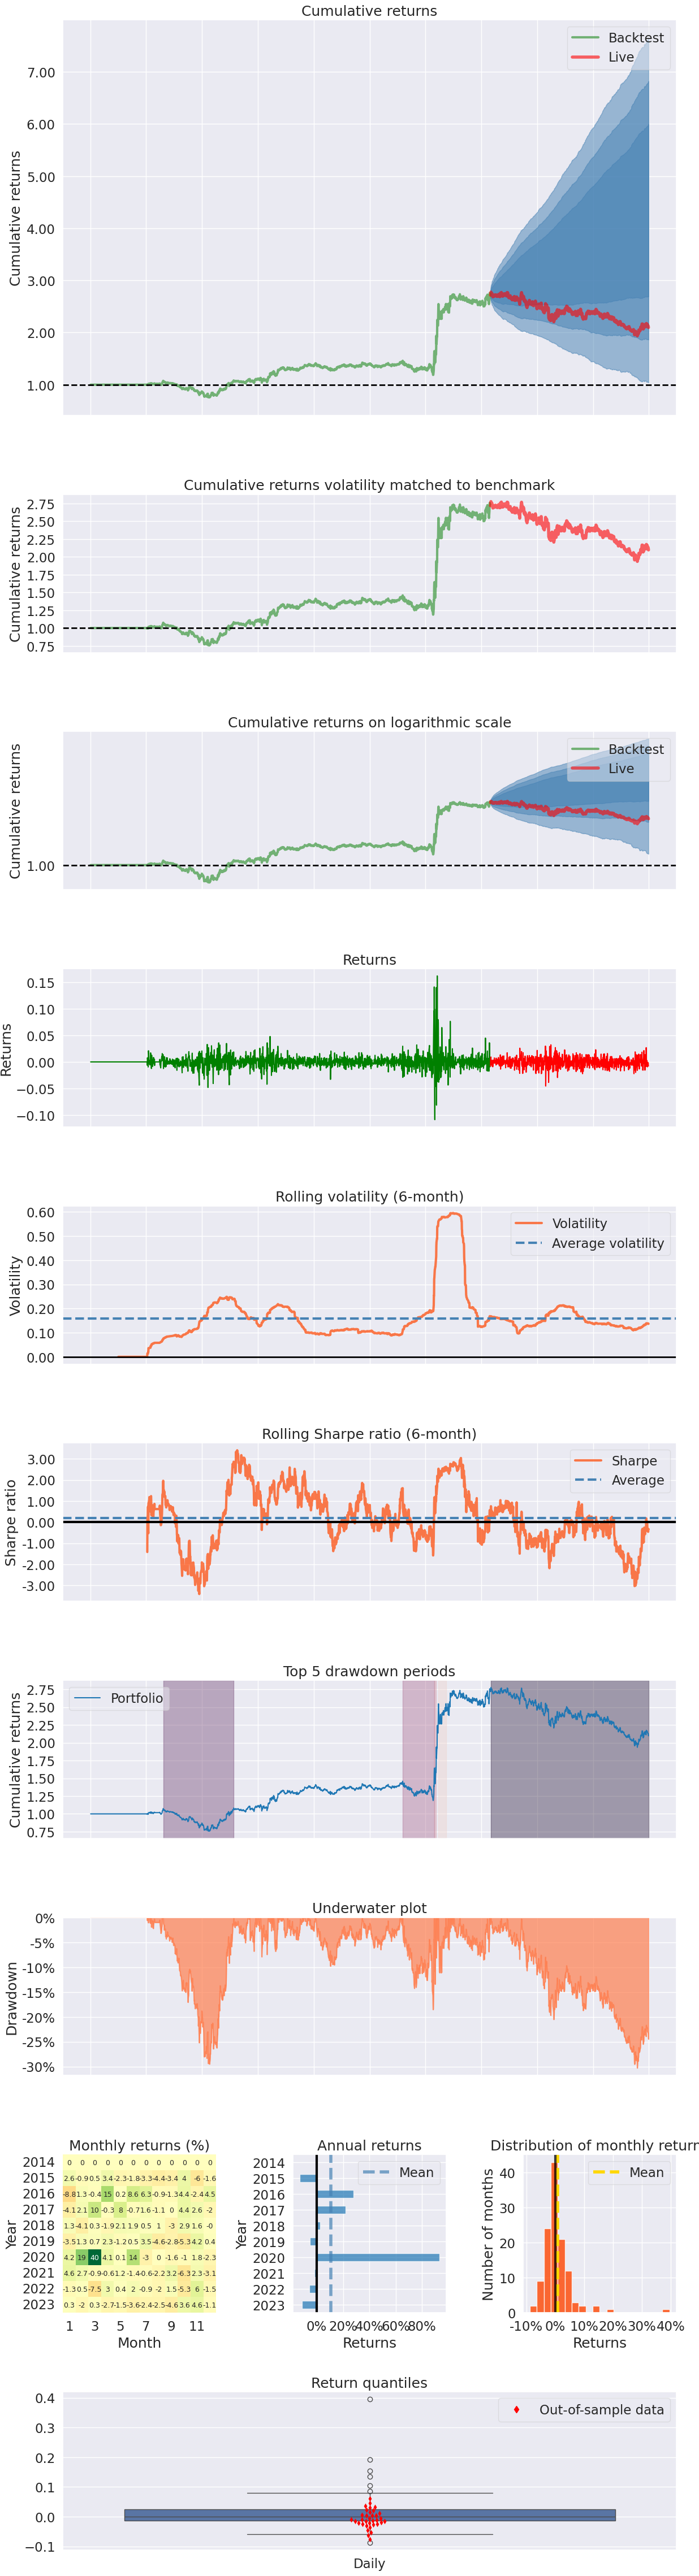

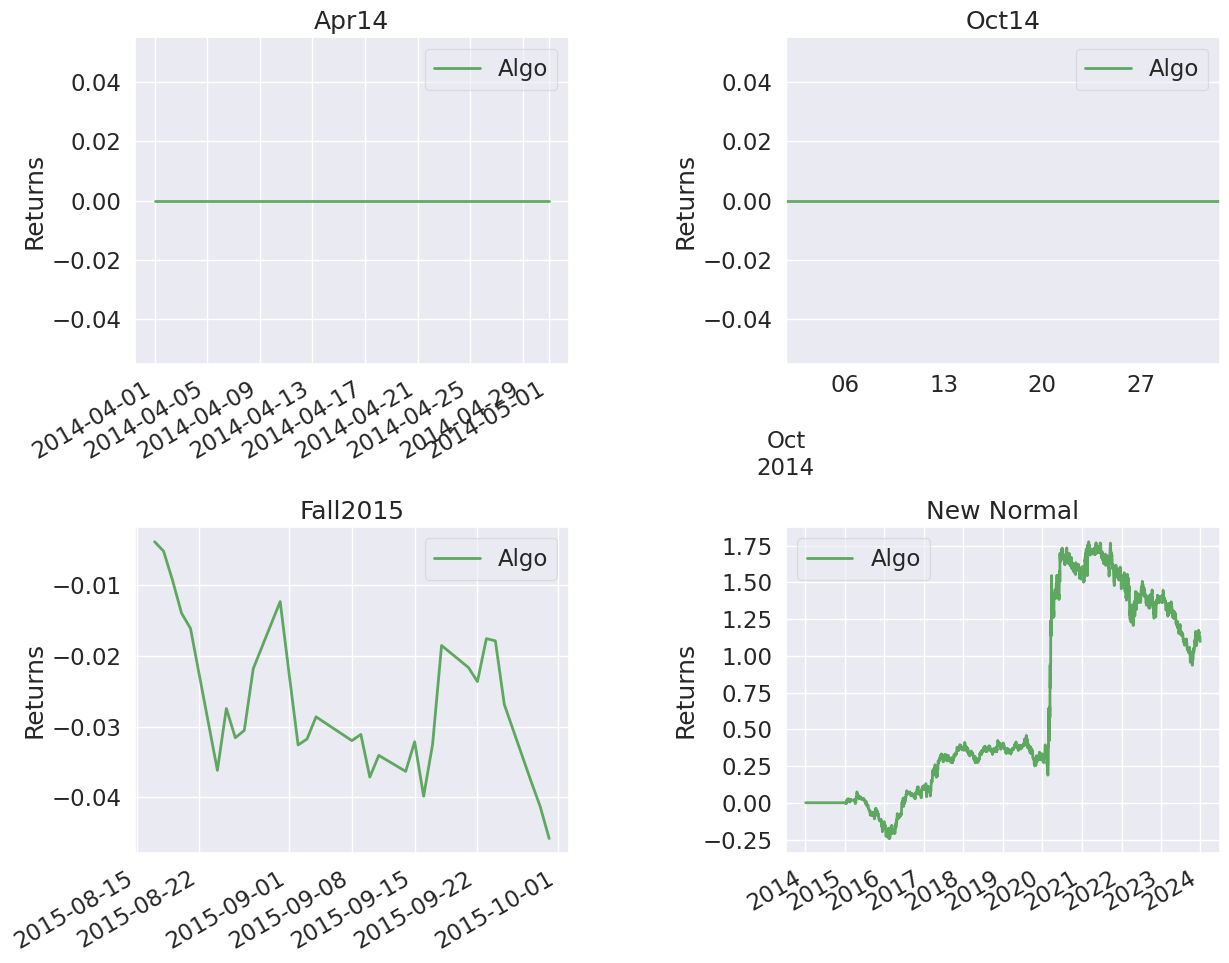

In [16]:
pf.create_full_tear_sheet(returns, live_start_date=stock_dict[stock_list[0]]['Close'].index[obs])